# Part 2 - Network load evaluation


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from tqdm import tqdm, trange

from package import constants
from package.connectivity import bfs_is_connected
# from networkx import erdos_renyi_graph, random_regular_graph, adjacency_matrix
import networkx as nx

N = 10000

In [2]:
from package.graph_utilities import leaves, n_closest, arg_n_smallest, select_nodes

## 2.1

We first define the two networks, also attaching and defining which nodes of the network are servers and which are routers.

### r-Regular Graph:


In [3]:
k = constants.n_ports//2
# create core random routers graph
rrg = nx.random_regular_graph(d = k, n=N//k+1)
while not bfs_is_connected(rrg):
    rrg = nx.random_regular_graph(d = k, n=N//k+1)

# add endpoints
for n in list(rrg.nodes()):
    endnodes = range(-n*k-1,-(n+1)*k-1,-1)
    rrg.add_nodes_from(endnodes, server=True)
    rrg.add_edges_from(zip([n]*k,endnodes))
rrg_servers = leaves(rrg)

### Fat-Tree graph
we assume that when considering only the number of jumps between two different servers, a fat-tree is equivalent to a tree.

In [98]:
ft = nx.full_rary_tree(r = k, n=sum(k**i for i in range(4)))

# define endpoints
ft_servers = leaves(ft)
ft.add_nodes_from(ft_servers, server=True)

In [99]:
len(ft_servers)

32768

### Simulation of Response Time
We can simulate the response time by computing the average throughput, and then sampling from some distributions

In [100]:
def response_time(g: nx.Graph, N: int, src: int, servers : set, targets :dict = None):
    targets = n_closest(g, N, src, servers) if targets is None else targets
    h = np.fromiter(targets.values(), dtype=int) # number of hops
    rtt = 2 * constants.propagation_time * h
    throughput = constants.capacity / rtt / sum(1/rtt)
    
    input_data = constants.input_data_size / N
    
    output_data = np.random.uniform(0, 2*constants.output_data_size / N, N)
    # uniform distribution in [0, 2 * output_size / N]
    
    transferred_data = input_data + output_data + input_data*constants.packet_overhead
    transfer_time = transferred_data / throughput
    
    
    computation_time = constants.setup_time + np.random.exponential(constants.mean_total_compute_time/N, N)
    
    return max(computation_time + transfer_time)

response_time(rrg, 1000, -1, select_nodes(rrg, server=True))

10155.38137744872

### Mean Response time
This is the same thing as above, but this time no sampling is involved and only the mean is taken.

```
Algo(h):
    h <- ...
   
```

In [101]:
def mean_response_time(g: nx.Graph, N: int, src: int, servers : set, targets :dict = None):
    targets = n_closest(g, N, src, servers) if targets is None else targets
    h = np.fromiter(targets.values(), dtype=int) # number of hops
    rtt = 2 * constants.propagation_time * h
    throughput = min( constants.capacity / rtt / sum(1/rtt) )
    
    input_data = constants.input_data_size / N
    
    output_data = constants.output_data_size / N
    # uniform distribution in [0, 2 * output_size / N]
    
    transferred_data = input_data + output_data + input_data*constants.packet_overhead
    transfer_time = transferred_data / throughput
    
    
    computation_time = constants.setup_time + constants.mean_total_compute_time/N
    
    return computation_time + transfer_time

mean_response_time(rrg, 1000, -1, select_nodes(rrg, server=True))

6820.463692799909

## 2.2 Simulation

In [102]:
N = 10000

def simulation(g, N):
    sn = select_nodes(g, server=True)
    
    src= next(iter(sn))
    sp = sorted(n_closest(g, N, src, sn).items(), key = lambda x: x[1])
    sp = {n:dict(sp[:n]) for n in range(1, N+1)}
    
    trials = pd.DataFrame(dict(
        N = list(range(1, N+1)),
    ))

    tqdm.pandas(desc='Response Simulation')
    trials['R'] = trials.N.progress_map(
        lambda n: mean_response_time(g, n, src, sn, sp[n])
    )
    return trials


In [103]:
trials = pd.concat([
    simulation(ft,  N),
    simulation(rrg, N)
], 
    keys=['Fat-Tree','Jellyfish'],
    names=['kind', 'id']
)
trials = trials.reset_index(level='kind').reset_index(drop=True)
trials

Response Simulation: 100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1011.67it/s]


,kind,N,R
0,Fat-Tree,1,35488.457600
1,Fat-Tree,2,21088.457600
2,Fat-Tree,3,16288.457600
3,Fat-Tree,4,13888.457600
4,Fat-Tree,5,12448.457600
...,...,...,...
19995,Jellyfish,9996,8637.163522
19996,Jellyfish,9997,8636.968593
19997,Jellyfish,9998,8636.773702
19998,Jellyfish,9999,8636.578851


In [104]:
R_baseline = constants.setup_time + constants.mean_total_compute_time
trials['R_scaled'] = trials.R / R_baseline

### Response Plot:

Text(9000, 0.95, 'baseline')

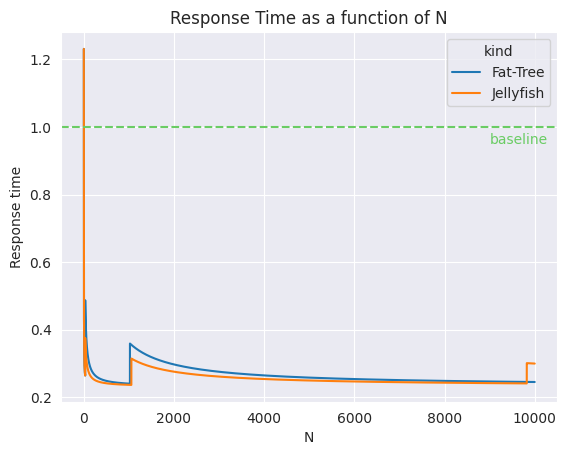

In [105]:
sns.set_style('darkgrid')
baseline_color = sns.color_palette('muted')[2]
ax = sns.lineplot(
    trials, 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (9000, .95), color = baseline_color)

## 2.3 Job Cost

In [106]:
# E[Theta]
mean_server_time = lambda N: N *constants.setup_time + constants.mean_total_compute_time

trials['Theta'] = trials.N.map(mean_server_time)
trials['S'] = trials.R + constants.xi * trials.Theta

S_baseline = R_baseline + constants.xi * mean_server_time(1)
trials['S_scaled'] = trials.S / S_baseline

trials

,kind,N,R,R_scaled,Theta,S,S_scaled
0,Fat-Tree,1,35488.457600,1.230956,28830,38371.457600,1.209960
1,Fat-Tree,2,21088.457600,0.731476,28860,23974.457600,0.755982
2,Fat-Tree,3,16288.457600,0.564983,28890,19177.457600,0.604719
3,Fat-Tree,4,13888.457600,0.481736,28920,16780.457600,0.529135
4,Fat-Tree,5,12448.457600,0.431788,28950,15343.457600,0.483822
...,...,...,...,...,...,...,...
19995,Jellyfish,9996,8637.163522,0.299589,328680,41505.163522,1.308774
19996,Jellyfish,9997,8636.968593,0.299583,328710,41507.968593,1.308863
19997,Jellyfish,9998,8636.773702,0.299576,328740,41510.773702,1.308951
19998,Jellyfish,9999,8636.578851,0.299569,328770,41513.578851,1.309040


Text(9000, 0.95, 'baseline')

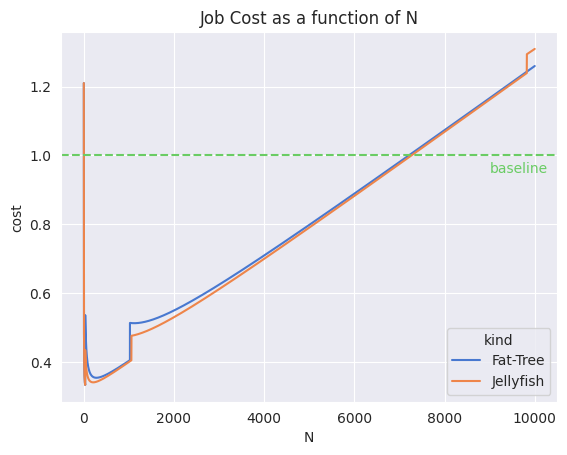

In [107]:
ax = sns.lineplot(
    trials, 
    x = 'N', 
    y = 'S_scaled',
    hue='kind',
    palette='muted'
)
ax.set(
    title = 'Job Cost as a function of N',
    ylabel = 'cost'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (9000, .95), color = baseline_color)


## 2.4 Analysis
Let $n$ denote the number of ports in a router and $k = n/2$.


### Spikes
We note that there are some spikes in the graph, specifically the first is at 31. This is because any node has $k - 1 = 31$ immediate neighbours (at 2 hops of distance):

```
        [ ]
        /|\
      a1...ak
```

After the 31 most immediate neighbours we need to contact further away nodes and as such the RTT increments greatly. Let $h_{max}(n)$ denote the maximum number of hops we need to perform to contact at least n different nodes, then:
-  $h_{max}(32) = 3$ for Jellyfish topology.
-  $h_{max}(32) = 4$ for Fat-Tree topology

In fact the next spikes are when the topology requires us to increase $h_{max}$ again, which is at $k^2 + k - 1$ for the _Jellyfish_ and $k^2 - 1$ for the _Fat-Tree_.

The fact that the _Jellyfish_ topology is better then _Fat-Tree_ in terms of $h_{max}(\cdot)$ is not a surprise since the point of using a r-regular random graph is exactly to reduce the average shortest path length between two nodes.  

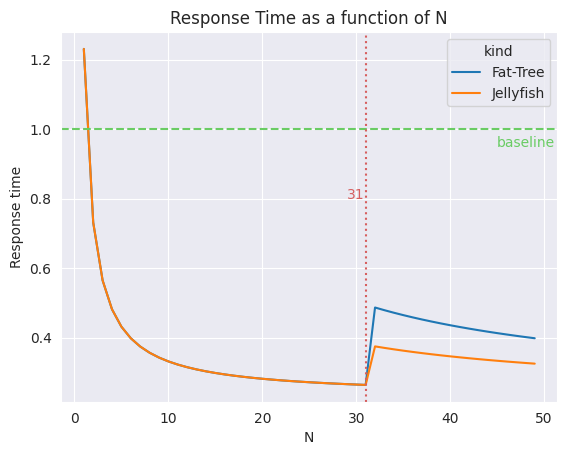

In [149]:
ax = sns.lineplot(
    trials[trials.N < 50], 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (45, .95), color = baseline_color)

red_muted = sns.color_palette('muted')[3]
plt.annotate('31', xy = (29, .8), color = red_muted)
plt.axvline(x=31, color=red_muted, linestyle = ':')

Text(1056, 0.8, 'k^2+k-1')

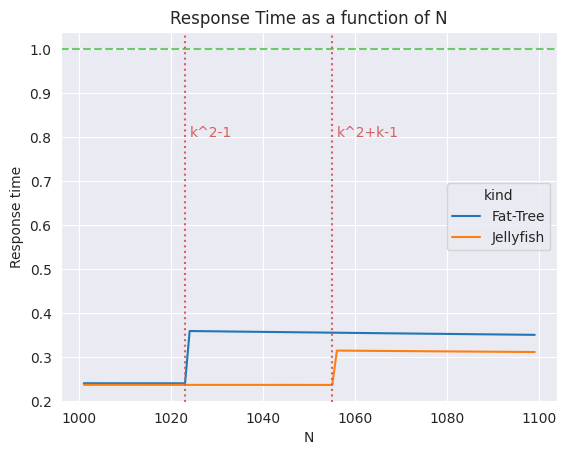

In [151]:
ax = sns.lineplot(
    trials[(1000 < trials.N) & (trials.N < 1100)], 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (45, .95), color = baseline_color)

red_muted = sns.color_palette('muted')[3]
plt.axvline(x=k**2-1, color=red_muted, linestyle = ':')
plt.annotate('k^2-1', xy = (k**2, .8), color = red_muted)
plt.axvline(x=k-1+k**2, color=red_muted, linestyle = ':')
plt.annotate('k^2+k-1', xy = (k+k**2, .8), color = red_muted)

### Best cost

As expected from the spikes and since the term $E[\Theta]$ is linear in $n$ the best cost is reached early on: at $N=31$ we find the best cost both for _Jellyfish_ and _Fat-Tree_. 

This is expected due to the spikes in $R$ that we previously analyzed.

In [143]:
best_cost = trials.S.min()

trials[trials.S == best_cost]

,kind,N,R,R_scaled,Theta,S,S_scaled
30,Fat-Tree,31,7617.489858,0.264221,29730,10590.489858,0.333948
10030,Jellyfish,31,7617.489858,0.264221,29730,10590.489858,0.333948


### Best time
The best time is obtained by the _Jellyfish_ topology right before the 2-nd spike of $R$.

In [146]:
best_time = trials.R.min()

trials[trials.R == best_time]

,kind,N,R,R_scaled,Theta,S,S_scaled
11054,Jellyfish,1055,6813.581859,0.236337,60450,12858.581859,0.405467


### Overall considerations
Overall the _Jellyfish_ topology performs better and cheaper than the _Fat-Tree_.
